In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [57]:
import os
import sys
import json
import re
from tqdm import tqdm
from typing import NamedTuple
import random

# libs to work with text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
from torch import default_generator, randperm
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from torch._utils import _accumulate

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score

%matplotlib inline

In [3]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# DEVICE = "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [4]:
# get the data
text_df = pd.read_csv('/kaggle/input/origin-or-fake-news-dataset/origin_fake.csv')

In [5]:
text_df.head()

,url,title_origin,body_origin,title_fake_1,title_fake_2,title_fake_3,body_fake_1,body_fake_2,body_fake_3
0,https://quote.rbc.ru/news/article/668e3ab79a79...,Forbes узнал о планах IT-компании «Омега» пров...,Cоздатель программного обеспечения для государ...,Forbes сообщил о намерении IT-компании «Омега»...,"Forbes выяснил, что IT-компания «Омега» планир...","Forbes узнал, что IT-компания «Омега» планируе...",Создатель программного обеспечения для госучре...,Создатель программного обеспечения для госстру...,Создатель программного обеспечения для государ...
1,https://quote.rbc.ru/news/article/668d7daf9a79...,Мосбиржа и СПБ Биржа сообщили о результатах об...,"На Мосбирже инвесторы обменяли 42,4 млн акций ...",Мосбиржа и СПБ Биржа объявили результаты обмен...,Мосбиржа и СПБ Биржа объявили о результатах об...,Московская биржа и СПБ Биржа объявили о резуль...,"На Мосбирже инвесторы обменяли 42,4 миллиона а...","На Московской бирже инвесторы обменяли 42,4 ми...",На Московской бирже было проведено обмен акция...
2,https://quote.rbc.ru/news/article/668d3e489a79...,«Газпромбанк Инвестиции» назвали топ-5 акций п...,Эксперты «Газпромбанк Инвестиций» отобрали пят...,"""Топ-5 акций, которые могут вырасти при повыше...","""Топ-5 акций, которые могут вырасти при повыше...","""Топ-5 акций, которые назвал «Газпромбанк Инве...","Специалисты ""Газпромбанк Инвестиций"" составили...","Специалисты ""Газпромбанк Инвестиций"" составили...","Специалисты ""Газпромбанк Инвестиций"" составили..."
3,https://quote.rbc.ru/news/article/668cff319a79...,Акции «Группы ГАЗ» взлетели на 22% на решении ...,Бумаги компании подскочили после решения суда ...,"""Ценные бумаги «Группы ГАЗ» резко подскочили н...","""Котировки акций «Группы ГАЗ» поднялись на 22%...","""Ценные бумаги «Группы ГАЗ» поднялись на 22%, ...",После того как суд принял решение частично удо...,"""После того как суд принял решение частично уд...",После того как суд принял решение частично удо...
4,https://quote.rbc.ru/news/article/6687af6f9a79...,Индекс Мосбиржи впервые за две недели упал ниж...,Российский рынок акций снижается на фоне дивид...,"""Индекс Московской биржи впервые за последние ...","""Индекс Московской биржи впервые за последние ...","""Индекс Московской биржи впервые за последние ...",Российский рынок акций падает из-за дивидендны...,Российский рынок акций падает из-за дивидендны...,Российский рынок акций испытывает снижение из-...


In [6]:
"""
    first we need to gather all the texts to build a corpus,
    it might be beneficial to add tickers names and description along with 
    finantial terminology
"""
# getting all stopwords and punktuations
nltk.download('stopwords')
nltk.download('punkt')
# set the language corpus
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)


# collect all textual data
documents = text_df.title_origin.to_list() + text_df.body_origin.to_list() + text_df.title_fake_1.to_list() + \
    text_df.title_fake_2.to_list() + text_df.title_fake_3.to_list() + text_df.body_fake_1.to_list() + \
        text_df.body_fake_2.to_list() + text_df.body_fake_3.to_list()

# delate puntktuations
def preprocess_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word not in stop_words and word not in punctuation]
    return " ".join(filtered_words)

# preprocess text corpus
documets = list(map(lambda x: preprocess_text(x), documents))

# convert into array vec
documents = np.array(documents)

# create a tf-idf vectorizer
vectorizer = TfidfVectorizer()
# build representation matrix
vectorizer.fit(documents)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TfidfVectorizer()

In [7]:
vectorizer.get_feature_names_out().shape

(6924,)

In [8]:
"""
    For now we want to make text pairs to compare
    similarities list shows whether two texts similar or not based on
    their words representation
"""
text1, text2, similarities = [], [], []

for idx in tqdm(range(len(text_df))):
    # get values from a slice
    href, title_or, body_or, title_f1, title_f2, title_f3, body_f1, body_f2, body_f3 = text_df.loc[idx]

    # make combinations without repits
    title_comb = combinations([title_or, title_f1, title_f2, title_f3], 2)
    body_comb = combinations([body_or, body_f1, body_f2, body_f3], 2)

    # collect into lists
    for (_t1, _t2) in title_comb:
        text1.append(_t1)
        text2.append(_t2)
        # they are similar, that is why 1 is the second
        similarities.append([0, 1])

100%|██████████| 501/501 [00:00<00:00, 17883.49it/s]


In [9]:
# make indeces combinations
paraph_comb = list(combinations([i for i in range(0, len(text_df))], 2))

# shuffle combinations
random.seed(10)
random.shuffle(paraph_comb)

print(len(paraph_comb))

# take only original titles and bodies
for idx, (idx_col1, idx_col2) in tqdm(enumerate(paraph_comb[:5000])):
    if idx % 2 == 0:
        text1.append(text_df.loc[idx_col1]['title_origin'])
        text2.append(text_df.loc[idx_col2]['title_origin'])
        similarities.append([1, 0])
    else:
        text1.append(text_df.loc[idx_col1]['body_origin'])
        text2.append(text_df.loc[idx_col2]['body_origin'])
        similarities.append([1, 0])

125250


5000it [00:00, 12255.96it/s]


In [10]:
text1 = np.array(text1)
text2 = np.array(text2)
similarities = np.array(similarities)

texts = np.vstack((text1, text2)).T

In [11]:
texts.shape

(8006, 2)

In [12]:
class TextSimilarityDataSet(Dataset):
    def __init__(self, vectorizer, text_pairs: np.ndarray, similarity_class: np.ndarray):
        self.text_pairs = text_pairs
        self.similarity_class = similarity_class
        self.vectorizer = vectorizer

    def __len__(self) -> int:
        return len(self.similarity_class)

    def __getitem__(self, idx):
        text1, text2 = self.text_pairs[idx]
        vec1 = self.vectorizer.transform([text1]).toarray().flatten()
        vec2 = self.vectorizer.transform([text2]).toarray().flatten()
        return np.float32(np.concatenate((vec1, vec2))), np.float32(self.similarity_class[idx])

In [34]:
class SiamesTextClassifier(nn.Module):
    def __init__(self, vectorizer, input_shape=6924):
        super().__init__()

        self.vectorizer = vectorizer
        
        self.flatten = nn.Flatten()
        
        torch.manual_seed(42)
        self.linear_layers = nn.Sequential(
            nn.Linear(2* input_shape, 2* 3812),
            nn.ReLU(),
            nn.Linear(2* 3812, 2 *1906),
            nn.ReLU(),
            nn.Linear(2* 1906, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_layers(x)
        output = nn.Softmax(dim=1)(output)
        return output

---
Dataset prep

In [14]:
x_train, x_test, y_train, y_test = train_test_split(texts, similarities, test_size=0.2, 
                                                    shuffle=True, random_state=42)

In [15]:
x_train.shape, y_train.shape

((6404, 2), (6404, 2))

In [23]:
np.unique(list(map(lambda x: np.argmax(x), y_train)), return_counts=True)

(array([0, 1]), array([4024, 2380]))

In [24]:
np.unique(list(map(lambda x: np.argmax(x), y_test)), return_counts=True)

(array([0, 1]), array([976, 626]))

In [25]:
x_test.shape, y_test.shape

((1602, 2), (1602, 2))

In [26]:
train_dataset = TextSimilarityDataSet(vectorizer, x_train, y_train)
test_dataset = TextSimilarityDataSet(vectorizer, x_test, y_test)

In [27]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
dataloaders = {'train': train_dataloader,
               'test': test_dataloader}

dataset_sizes = {'train': len(train_dataloader),
                 'test': len(test_dataloader)}

---
train and run functions

In [29]:
def train_model(model, epochs, criterion, optimizer, sheduler, dataloaders, dataset_sizes, print_stages=2):

    train_loss, test_loss = [], []

    for epoch in range(epochs):
        
        if epoch % print_stages == 0:
            if epoch:
                print('-'*10)
            print(f'Epoch {epoch}', end='\t')

        for phase in ['train', 'test']:

            if phase == 'train':
                model.train()
            elif phase == 'test':
                model.eval()
            
            total_loss = 0
            
            for (_x, _y) in dataloaders[phase]:
                _x_d, _y_d = _x.to(DEVICE), _y.to(DEVICE)

                optimizer.zero_grad()

                pred = model(_x_d)
                loss = criterion(pred, _y_d)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                elif phase == 'test':
                    total_loss += loss.item()

            if phase == 'train':
                train_loss.append(total_loss)
                if epoch % print_stages == 0:
                    print(f'Train Loss: {total_loss:.5f}', end='\t')
            elif phase == 'test':
                test_loss.append(total_loss)
                if epoch % print_stages == 0:
                    print(f'Test Loss: {total_loss:.5f}', end='\n\n')
                    
        if scheduler is not None:
            scheduler.step()

#         if epoch % print_stages == 0:
#             print('Epoch', epoch, 'LOSS', total_loss)
            # clear_output(True)
            # plt.plot(train_loss, label='train')
            # plt.plot(test_loss, label='test')
            # plt.yscale('log')
            
    return train_loss, test_loss

---
training

In [35]:
model = SiamesTextClassifier(vectorizer).to(DEVICE)

In [36]:
lr = 1e-4
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)

In [37]:
train_losses, test_losses = train_model(model, 100, loss_function, optimizer, scheduler, dataloaders, dataset_sizes, 3)

Epoch 0	Train Loss: 94.60651	Test Loss: 4.32256

----------
Epoch 3	Train Loss: 0.01597	Test Loss: 1.92856

----------
Epoch 6	Train Loss: 0.00271	Test Loss: 2.17854

----------
Epoch 9	Train Loss: 0.00166	Test Loss: 2.24909

----------
Epoch 12	Train Loss: 0.00145	Test Loss: 2.26954

----------
Epoch 15	Train Loss: 0.00138	Test Loss: 2.27611

----------
Epoch 18	Train Loss: 0.00136	Test Loss: 2.27819

----------
Epoch 21	Train Loss: 0.00136	Test Loss: 2.27874

----------
Epoch 24	Train Loss: 0.00136	Test Loss: 2.27891

----------
Epoch 27	Train Loss: 0.00136	Test Loss: 2.27895

----------
Epoch 30	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 33	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 36	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 39	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 42	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 45	Train Loss: 0.00136	Test Loss: 2.27896

----------
Epoch 48	Train Loss: 0.00136	Test Loss: 2.2

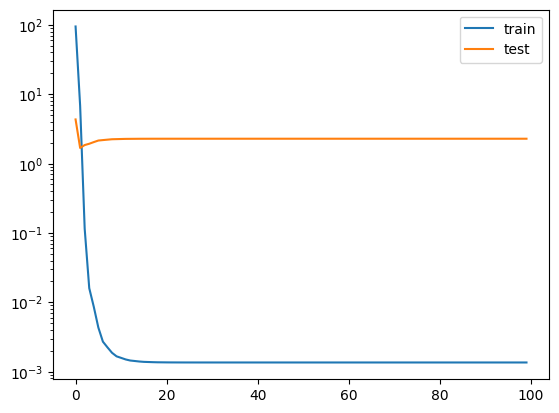

In [41]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')

plt.yscale('log')
plt.legend()
plt.show()

In [52]:
def run_model(model, dataloader):
    model.eval()
    prediction = np.array([])
    for (_x, _y) in dataloader:
        _x_d = _x.to(DEVICE)
        
        pred = model(_x_d).detach().cpu().numpy()
        
        if len(prediction) < 1:
            prediction = pred
        else:
            prediction = np.concatenate((prediction, pred), axis=0)
            
    return prediction

In [53]:
test_pred = run_model(model, dataloaders['test'])
train_pred = run_model(model, dataloaders['train'])

In [56]:
test_labels = np.argmax(test_pred, axis=1)
train_labels = np.argmax(train_pred, axis=1)

In [60]:
accuracy_score(test_labels, np.argmax(y_test, axis=1))

0.9900124843945068

In [61]:
accuracy_score(train_labels, np.argmax(y_train, axis=1))

1.0